In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

import logging

import numpy as np
import plotly.express as px

import semg_bss

# Configure log file
LOG_FILE = "semg_bss.log"
logging.basicConfig(filename=LOG_FILE, encoding='utf-8', level=logging.INFO, filemode="w")

DATA_DIR = "/home/nihil/Scrivania/hyser_dataset"
FS_EMG = 2048  # sampling frequency

SEED = 42

# Decomposition of sEMG signals

## 1. Introduction to ICA-based Blind Source Separation
The original ICA formulation from [Hyvarinen et al.](https://www.cs.helsinki.fi/u/ahyvarin/papers/NN00new.pdf) relies on instantaneous mixing:

$\mathbf{X} = \mathbf{A}\mathbf{S}$

where

- $\mathbf{X}$ is the $N_\text{recording} \times N_\text{samples}$ matrix of observables (i.e. the sEMG recording);
- $\mathbf{S}$ is the $N_\text{components} \times N_\text{samples}$ matrix of the original signals (i.e. the MUAPs);
- $\mathbf{A}$ is the $N_\text{recording} \times N_\text{components}$ mixing matrix.

The FastICA algorithm was developed to address this formulation.

However, since the muscle fibers act as a low-pass filter, the resulting sEMG signal is a convolutive mixture of the MUAPs ([Holobar et al.](https://ieeexplore.ieee.org/document/4291854)):

$x_i(k)=\sum_{l=0}^{L-1} \sum_{j=1}^N h_{ij}(l)s_j(k-l)+n_i(k);\;\;\;\;i=1,\dots,M$

namely the matrix of electrode recordings $\mathbf{X}$ is obtained by performing a 1D convolution between a mixing filter $\mathbf{A}$ with size $L$ and the actual spike trains $\mathbf{S}$.

[Thomas et al.](https://ieeexplore.ieee.org/document/1605245) adapted FastICA in order to address convolutive mixtures.

## 2. Hyser dataset
This dataset contains the sEMG recordings of 20 subjects, acquired while they were performing a certain task. In particular, the dataset is divided into 5 subsets, based on the task performed:

- **PR**: subjects were instructed to perform 34 hand gestures.
- **MVC**: subjects were instructed to perform their maximal voluntary isometric contraction.
- **1 DoF**: subjects were instructed to perform isometric contractions of each single finger.
- **N DoF**: subjects were instructed to perform isometric contractions of a combination of multiple fingers.
- **Random**: subjects were allowed to randomly perform isometric contractions of muscles corresponding to any combination of fingers with any force trajectory.

The sEMG data were collected using 4 arrays of 64 electrodes each (264 in total), with a sampling rate of 2048 Hz. The ground truth force trajectories of the five fingers were acquired using five separate sensor-amplifier pairs with a sampling rate of 100 Hz.

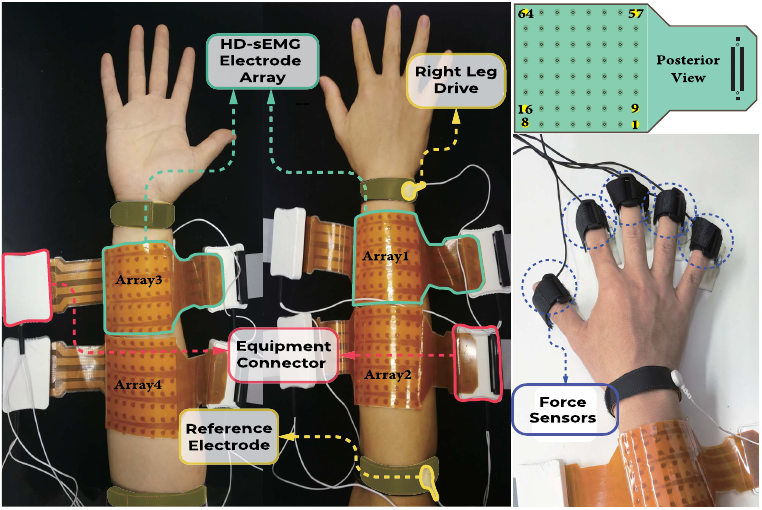

In particular, the first two arrays recorded the activity of the extensor muscle, whereas the remaining two arrays recorded the activity of the flexor muscle.

## 3. Offline decomposition

For the offline decomposition, let's focus on the N DoF dataset: for each subject, we have

- 2 recording sessions;
- 15 tasks (one per combination of fingers);
- 2 trials.

resulting in 60 sEMG recordings with 256 channels.

For instance, let's focus on the first subject in the first session: let's visualize the first 15 channels of the sEMG recorded in the first trial and for the combination thumb + index.

In [ ]:
sub_emg = semg_bss.hyser.load_ndof(DATA_DIR, subject=0, session=0, sig_type="preprocess", verbose=True)

comb = 0
trial = 0
emg = sub_emg[comb, trial]  # load record for given finger and trial

semg_bss.plot_signal(emg[:15], fig_size=(600, 1000), fs=FS_EMG, n_cols=5)

The first step is signal extension: since we have a convolutive mixture, we must extend the signal by adding delayed copies, resulting in $f_e \times M$ channels (where $M$ is the n. of channels in the original signal). In particular, we set $f_e=1000/M\approx4$.

Then, the extended signal is centered and whitened via eigenvalue decomposition.

In [ ]:
f_e = 4
emg_ext = semg_bss.preprocessing.extend_signal(emg, f_e)
emg_center = semg_bss.preprocessing.center_signal(emg_ext)
emg_white, _ = semg_bss.preprocessing.whiten_signal(emg_center)

fig = px.imshow(np.hstack([np.corrcoef(emg_ext), np.corrcoef(emg_white)]))
fig.show()

The logic behind FastICA and source improvement is encapsulated inside the `EmgSeparator` class: let's create one using $100$ target components and $f_e=4$.

In [4]:
emg_separator = semg_bss.EmgSeparator(
    max_comp=300,
    fs=FS_EMG,
    f_e=f_e,
    seed=SEED
)

Let's train the instance on the un-whitened sEMG signal.

In [ ]:
%%time

# Train instance on the given signal
firings = emg_separator.fit_transform(emg)
print(f"Extracted {emg_separator.n_mu} MUs.")
# Plot it
semg_bss.raster_plot(firings, fig_size=(600, 1000))

In [ ]:
muaps = emg_separator.project(emg)
semg_bss.plot_signal(muaps, fig_size=(600, 1000), fs=FS_EMG, n_cols=5)

In [11]:
print("Correlation between firing rate and neg-entropy:", firings["Firing rate"].corr(firings["Neg-entropy"]))

Correlation between firing rate and neg-entropy: -0.3410174915086892
